- Hatmap
- Melhorar o plot de imagens
- Propor algo novo

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
import cv2
from torch.autograd import Variable
import random
import shutil, sys
import pandas as pd
from PIL import Image
from PIL import ImageFile
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
#model_name = "densenet"

# Number of classes in the dataset
#num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for


# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

#num_epochs = 500

In [3]:
test = 2

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val', 'test']}

# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                    batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# trans = ['train','val','test']
# categories = ['train','val','test']

class_names = image_datasets['train'].classes

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#device.reset()

Initializing Datasets and Dataloaders...


In [5]:
# Path to data
data_dir = '/home/jimi/dissertacao/covid19/datasets/80-20/'
train_dir = data_dir+'train/'
test_dir = data_dir+'test/'
val_dir = data_dir+'val/'

normal_dir = data_dir+'normal/'
pneumonia_dir = data_dir+'pneumonia/'
covid_dir = data_dir+'covid/'

len_covid = len([iq for iq in os.scandir(normal_dir)])
len_normal = len([iq for iq in os.scandir(pneumonia_dir)])
len_pneumonia = len([iq for iq in os.scandir(covid_dir)])

len_train_dir = len([iq for iq in os.scandir(train_dir+'covid/')]) + len([iq for iq in os.scandir(train_dir+'normal/')]) + len([iq for iq in os.scandir(train_dir+'pneumonia/')])
len_test_dir = len([iq for iq in os.scandir(test_dir+'covid/')]) + len([iq for iq in os.scandir(test_dir+'normal/')]) + len([iq for iq in os.scandir(test_dir+'pneumonia/')])
len_val_dir = len([iq for iq in os.scandir(val_dir+'covid/')]) + len([iq for iq in os.scandir(val_dir+'normal/')]) + len([iq for iq in os.scandir(val_dir+'pneumonia/')])

print('Files per classes')
print("----"*10)
print("normal : ", len_covid)

print("pneumonia : ", len_normal)

print("covid : ", len_pneumonia)

print("-"*20)

print('Train, test, validation')

print("-"*20)

print("len_train_dir : ", len_train_dir)

print("len_test_dir : ", len_test_dir)

print("len_val_dir : ", len_val_dir)



Files per classes
----------------------------------------
normal :  4023
pneumonia :  4035
covid :  4105
--------------------
Train, test, validation
--------------------
len_train_dir :  9632
len_test_dir :  31
len_val_dir :  2409


In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, 
                model_name, lr, batch_size, opt_name, crt_name):
    since = time.time()
    is_inception = False
    
    #tensorboard
    writer = SummaryWriter(f'runs/dg_{model_name}_lr={lr}_epoch={num_epochs}_batch_size={batch_size}')
    step = 0

    val_acc_history = []
    val_loss_history = []
    
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            writer.add_scalar('training loss', loss, global_step=step)
            writer.add_scalar('training accuracy', epoch_acc, global_step=step)
            step += 1
            
            #only to plot the graph
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()
        
        
    time_elapsed = time.time() - since
    print()
    print('#'*30)
    print('------ Summary ------')
    print(f'model -> {_model}')
    print(f'epochs -> {_epochs}')
    print(f'lr -> {_lrs}')
    print(f'batch size -> {_batch}')
    print(f'optimizer -> {opt_name}'), 
    print(f'criteriun -> {crt_name}')
    print()
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('#'*30)
    
    plt.figure(figsize=(13, 4))
    plt.subplot(1, 2, 1)
    plt.plot(val_acc_history, label="Validation Accuracy")
    plt.plot(train_acc_history, label="Validation Loss")
    plt.title('Accuracy and Loss in Validation Dataset')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_loss_history, label="val_loss_history")
    plt.plot(train_loss_history, label="train_loss_history")
    plt.legend()
    plt.tight_layout()
    plt.savefig('hist_'+_model+'_opt_'+opt_name+'_crt_'+crt_name+'.png')
    plt.show()

    print()

    print('==== END ====')


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [46]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 3, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [47]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [48]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [49]:
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('cm_'+title+'.png')


==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.5567 Acc: 0.7990
val Loss: 0.3143 Acc: 0.9132

Epoch 1/299
----------
train Loss: 0.3074 Acc: 0.9016
val Loss: 0.2554 Acc: 0.9286

Epoch 2/299
----------
train Loss: 0.2613 Acc: 0.9170
val Loss: 0.2161 Acc: 0.9394

Epoch 3/299
----------
train Loss: 0.2377 Acc: 0.9222
val Loss: 0.1965 Acc: 0.9423

Epoch 4/299
----------
train Loss: 0.2197 Acc: 0.9301
val Loss: 0.1828 Acc: 0.9469

Epoch 5/299
----------
train Loss: 0.2093 Acc: 0.9340
val Loss: 0.1759 Acc: 0.9494

Epoch 6/299
----------
train Loss: 0.2044 Acc: 0.9302
val Loss: 0.1689 Acc: 0.9527

Epoch 7/299
----------
train Loss: 0.1984 Acc: 0.9351
val Loss: 0.1668 Acc: 0.9523

Epoch 8/299
----------
train Loss: 0.1857 Acc: 0.9410
val Loss: 0.1760 Acc: 0

train Loss: 0.1182 Acc: 0.9590
val Loss: 0.0920 Acc: 0.9680

Epoch 94/299
----------
train Loss: 0.1111 Acc: 0.9617
val Loss: 0.0927 Acc: 0.9693

Epoch 95/299
----------
train Loss: 0.1149 Acc: 0.9618
val Loss: 0.0897 Acc: 0.9714

Epoch 96/299
----------
train Loss: 0.1142 Acc: 0.9607
val Loss: 0.0897 Acc: 0.9718

Epoch 97/299
----------
train Loss: 0.1134 Acc: 0.9618
val Loss: 0.0894 Acc: 0.9709

Epoch 98/299
----------
train Loss: 0.1098 Acc: 0.9631
val Loss: 0.0890 Acc: 0.9709

Epoch 99/299
----------
train Loss: 0.1097 Acc: 0.9627
val Loss: 0.0889 Acc: 0.9722

Epoch 100/299
----------
train Loss: 0.1102 Acc: 0.9597
val Loss: 0.0891 Acc: 0.9693

Epoch 101/299
----------
train Loss: 0.1101 Acc: 0.9621
val Loss: 0.0923 Acc: 0.9693

Epoch 102/299
----------
train Loss: 0.1139 Acc: 0.9601
val Loss: 0.0896 Acc: 0.9689

Epoch 103/299
----------
train Loss: 0.1098 Acc: 0.9614
val Loss: 0.0886 Acc: 0.9701

Epoch 104/299
----------
train Loss: 0.1154 Acc: 0.9589
val Loss: 0.0881 Acc: 0.9726


val Loss: 0.0826 Acc: 0.9714

Epoch 189/299
----------
train Loss: 0.1013 Acc: 0.9653
val Loss: 0.0815 Acc: 0.9759

Epoch 190/299
----------
train Loss: 0.1011 Acc: 0.9658
val Loss: 0.0814 Acc: 0.9734

Epoch 191/299
----------
train Loss: 0.0998 Acc: 0.9644
val Loss: 0.0830 Acc: 0.9755

Epoch 192/299
----------
train Loss: 0.0964 Acc: 0.9663
val Loss: 0.0831 Acc: 0.9709

Epoch 193/299
----------
train Loss: 0.1016 Acc: 0.9651
val Loss: 0.0827 Acc: 0.9705

Epoch 194/299
----------
train Loss: 0.1014 Acc: 0.9646
val Loss: 0.0870 Acc: 0.9693

Epoch 195/299
----------
train Loss: 0.1037 Acc: 0.9641
val Loss: 0.0819 Acc: 0.9730

Epoch 196/299
----------
train Loss: 0.1010 Acc: 0.9650
val Loss: 0.0854 Acc: 0.9701

Epoch 197/299
----------
train Loss: 0.1034 Acc: 0.9627
val Loss: 0.0821 Acc: 0.9718

Epoch 198/299
----------
train Loss: 0.1019 Acc: 0.9654
val Loss: 0.0805 Acc: 0.9747

Epoch 199/299
----------
train Loss: 0.0982 Acc: 0.9663
val Loss: 0.0803 Acc: 0.9743

Epoch 200/299
----------

train Loss: 0.0967 Acc: 0.9654
val Loss: 0.0760 Acc: 0.9759

Epoch 285/299
----------
train Loss: 0.0932 Acc: 0.9663
val Loss: 0.0813 Acc: 0.9709

Epoch 286/299
----------
train Loss: 0.0959 Acc: 0.9648
val Loss: 0.0792 Acc: 0.9763

Epoch 287/299
----------
train Loss: 0.0966 Acc: 0.9654
val Loss: 0.0837 Acc: 0.9689

Epoch 288/299
----------
train Loss: 0.0962 Acc: 0.9657
val Loss: 0.0764 Acc: 0.9763

Epoch 289/299
----------
train Loss: 0.0938 Acc: 0.9673
val Loss: 0.0753 Acc: 0.9763

Epoch 290/299
----------
train Loss: 0.0983 Acc: 0.9673
val Loss: 0.0755 Acc: 0.9751

Epoch 291/299
----------
train Loss: 0.0983 Acc: 0.9648
val Loss: 0.0754 Acc: 0.9755

Epoch 292/299
----------
train Loss: 0.0953 Acc: 0.9651
val Loss: 0.0813 Acc: 0.9747

Epoch 293/299
----------
train Loss: 0.0964 Acc: 0.9653
val Loss: 0.0881 Acc: 0.9672

Epoch 294/299
----------
train Loss: 0.0984 Acc: 0.9659
val Loss: 0.0766 Acc: 0.9768

Epoch 295/299
----------
train Loss: 0.0975 Acc: 0.9678
val Loss: 0.0777 Acc: 0

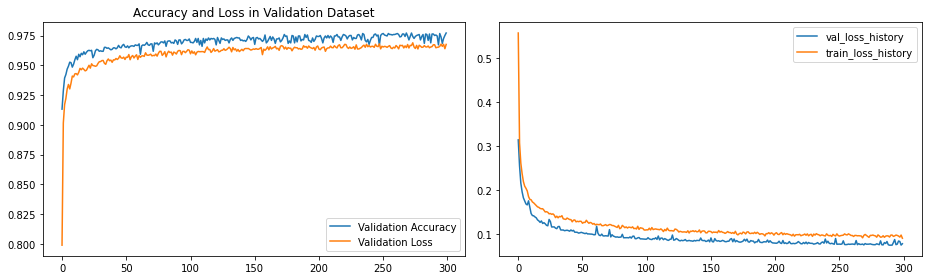


==== END ====
[[791   0   0]
 [  2 770  27]
 [  6  20 793]]

Sensitivity or recall total
0.9771689497716894

Sensitivity or recall per classes
[1.   0.96 0.97]

Precision
[0.99 0.97 0.97]

F1 Score
[0.99 0.97 0.97]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 1
criteriun -> 2

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -285.7825 Acc: 0.4383
val Loss: -590.8180 Acc: 0.3404

Epoch 1/299
----------
train Loss: -890.0951 Acc: 0.3435
val Loss: -1198.0694 Acc: 0.3416

Epoch 2/299
----------
train Loss: -1494.6983 Acc: 0.3429
val Loss: -1805.0861 Acc: 0.3421

Epoch 3/299
----------
train Loss: -2100.7056 Acc: 0.3466
val Loss: -2412.7816 Acc: 0.3425

Epoch 4/299
----------
train Loss: -2706.1923 Acc: 0.3458
val Loss: -3020.1276 Acc: 0.3445

Epoch 5/299
----------
train Loss: -

train Loss: -49303.1138 Acc: 0.3487
val Loss: -49787.2691 Acc: 0.3454

Epoch 82/299
----------
train Loss: -49911.9912 Acc: 0.3473
val Loss: -50394.9193 Acc: 0.3454

Epoch 83/299
----------
train Loss: -50491.2469 Acc: 0.3486
val Loss: -51002.1105 Acc: 0.3454

Epoch 84/299
----------
train Loss: -51110.0896 Acc: 0.3493
val Loss: -51609.4218 Acc: 0.3454

Epoch 85/299
----------
train Loss: -51726.6759 Acc: 0.3489
val Loss: -52216.9312 Acc: 0.3454

Epoch 86/299
----------
train Loss: -52337.6243 Acc: 0.3489
val Loss: -52824.4902 Acc: 0.3454

Epoch 87/299
----------
train Loss: -52927.8163 Acc: 0.3479
val Loss: -53432.0363 Acc: 0.3454

Epoch 88/299
----------
train Loss: -53544.7917 Acc: 0.3484
val Loss: -54039.5255 Acc: 0.3454

Epoch 89/299
----------
train Loss: -54133.0539 Acc: 0.3483
val Loss: -54646.8829 Acc: 0.3454

Epoch 90/299
----------
train Loss: -54743.9126 Acc: 0.3481
val Loss: -55254.1337 Acc: 0.3454

Epoch 91/299
----------
train Loss: -55352.1964 Acc: 0.3486
val Loss: -558

train Loss: -101351.6643 Acc: 0.3488
val Loss: -102022.8661 Acc: 0.3458

Epoch 168/299
----------
train Loss: -101930.7978 Acc: 0.3483
val Loss: -102630.2473 Acc: 0.3454

Epoch 169/299
----------
train Loss: -102566.1981 Acc: 0.3481
val Loss: -103237.7677 Acc: 0.3454

Epoch 170/299
----------
train Loss: -103204.5990 Acc: 0.3481
val Loss: -103845.4874 Acc: 0.3454

Epoch 171/299
----------
train Loss: -103731.9029 Acc: 0.3473
val Loss: -104452.8297 Acc: 0.3454

Epoch 172/299
----------
train Loss: -104353.8158 Acc: 0.3490
val Loss: -105060.1536 Acc: 0.3454

Epoch 173/299
----------
train Loss: -104991.0625 Acc: 0.3479
val Loss: -105667.5914 Acc: 0.3454

Epoch 174/299
----------
train Loss: -105558.8245 Acc: 0.3482
val Loss: -106274.8445 Acc: 0.3454

Epoch 175/299
----------
train Loss: -106179.7766 Acc: 0.3484
val Loss: -106882.4656 Acc: 0.3454

Epoch 176/299
----------
train Loss: -106803.7425 Acc: 0.3486
val Loss: -107489.7966 Acc: 0.3454

Epoch 177/299
----------
train Loss: -107341.

train Loss: -152176.9329 Acc: 0.3490
val Loss: -153043.5440 Acc: 0.3454

Epoch 252/299
----------
train Loss: -152755.8744 Acc: 0.3482
val Loss: -153650.6849 Acc: 0.3454

Epoch 253/299
----------
train Loss: -153365.2471 Acc: 0.3485
val Loss: -154258.0633 Acc: 0.3454

Epoch 254/299
----------
train Loss: -153983.6493 Acc: 0.3485
val Loss: -154865.6511 Acc: 0.3454

Epoch 255/299
----------
train Loss: -154597.8646 Acc: 0.3494
val Loss: -155473.0241 Acc: 0.3454

Epoch 256/299
----------
train Loss: -155173.6565 Acc: 0.3484
val Loss: -156080.3608 Acc: 0.3454

Epoch 257/299
----------
train Loss: -155798.7330 Acc: 0.3487
val Loss: -156687.7994 Acc: 0.3454

Epoch 258/299
----------
train Loss: -156357.3339 Acc: 0.3478
val Loss: -157294.9161 Acc: 0.3458

Epoch 259/299
----------
train Loss: -157015.9756 Acc: 0.3481
val Loss: -157902.4971 Acc: 0.3454

Epoch 260/299
----------
train Loss: -157668.0744 Acc: 0.3487
val Loss: -158510.1198 Acc: 0.3454

Epoch 261/299
----------
train Loss: -158213.

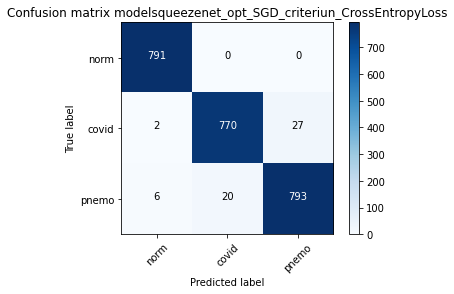

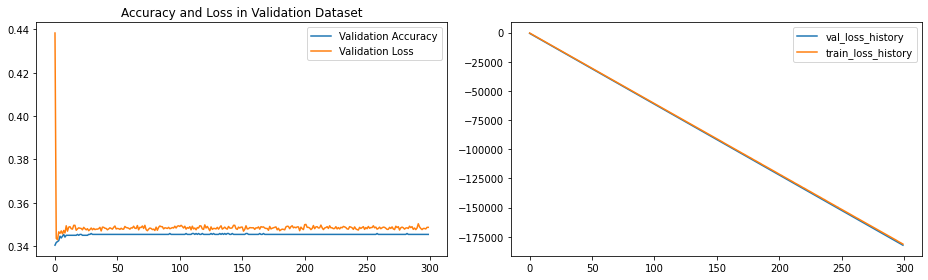


==== END ====
[[  3 665 123]
 [  0 799   0]
 [  0 788  31]]

Sensitivity or recall total
0.3457866334578663

Sensitivity or recall per classes
[0.   1.   0.04]

Precision
[1.   0.35 0.2 ]

F1 Score
[0.01 0.52 0.06]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.7661 Acc: 0.7051
val Loss: 0.4548 Acc: 0.8896

Epoch 1/299
----------
train Loss: 0.3851 Acc: 0.8945
val Loss: 0.2996 Acc: 0.9207

Epoch 2/299
----------
train Loss: 0.2895 Acc: 0.9233
val Loss: 0.2445 Acc: 0.9365

Epoch 3/299
----------
train Loss: 0.2454 Acc: 0.9320
val Loss: 0.2108 Acc: 0.9444

Epoch 4/299
----------
train Loss: 0.2209 Acc: 0.9377
val Loss: 0.1895 Acc: 0.9502

Epoch 5/299
----------
train Loss: 0.2038 Acc: 0.9395
val Loss: 0.1761 Ac

train Loss: 0.0854 Acc: 0.9708
val Loss: 0.0725 Acc: 0.9772

Epoch 91/299
----------
train Loss: 0.0868 Acc: 0.9697
val Loss: 0.0726 Acc: 0.9768

Epoch 92/299
----------
train Loss: 0.0880 Acc: 0.9711
val Loss: 0.0739 Acc: 0.9797

Epoch 93/299
----------
train Loss: 0.0879 Acc: 0.9700
val Loss: 0.0722 Acc: 0.9772

Epoch 94/299
----------
train Loss: 0.0874 Acc: 0.9692
val Loss: 0.0717 Acc: 0.9772

Epoch 95/299
----------
train Loss: 0.0861 Acc: 0.9700
val Loss: 0.0717 Acc: 0.9780

Epoch 96/299
----------
train Loss: 0.0885 Acc: 0.9709
val Loss: 0.0724 Acc: 0.9768

Epoch 97/299
----------
train Loss: 0.0854 Acc: 0.9724
val Loss: 0.0730 Acc: 0.9772

Epoch 98/299
----------
train Loss: 0.0839 Acc: 0.9724
val Loss: 0.0714 Acc: 0.9776

Epoch 99/299
----------
train Loss: 0.0842 Acc: 0.9724
val Loss: 0.0712 Acc: 0.9772

Epoch 100/299
----------
train Loss: 0.0859 Acc: 0.9699
val Loss: 0.0724 Acc: 0.9788

Epoch 101/299
----------
train Loss: 0.0824 Acc: 0.9720
val Loss: 0.0709 Acc: 0.9776

Ep

train Loss: 0.0792 Acc: 0.9711
val Loss: 0.0648 Acc: 0.9788

Epoch 187/299
----------
train Loss: 0.0767 Acc: 0.9741
val Loss: 0.0650 Acc: 0.9788

Epoch 188/299
----------
train Loss: 0.0770 Acc: 0.9717
val Loss: 0.0647 Acc: 0.9797

Epoch 189/299
----------
train Loss: 0.0785 Acc: 0.9726
val Loss: 0.0652 Acc: 0.9780

Epoch 190/299
----------
train Loss: 0.0769 Acc: 0.9726
val Loss: 0.0662 Acc: 0.9784

Epoch 191/299
----------
train Loss: 0.0753 Acc: 0.9716
val Loss: 0.0646 Acc: 0.9797

Epoch 192/299
----------
train Loss: 0.0755 Acc: 0.9753
val Loss: 0.0654 Acc: 0.9780

Epoch 193/299
----------
train Loss: 0.0785 Acc: 0.9718
val Loss: 0.0652 Acc: 0.9805

Epoch 194/299
----------
train Loss: 0.0758 Acc: 0.9735
val Loss: 0.0647 Acc: 0.9805

Epoch 195/299
----------
train Loss: 0.0783 Acc: 0.9721
val Loss: 0.0647 Acc: 0.9780

Epoch 196/299
----------
train Loss: 0.0766 Acc: 0.9756
val Loss: 0.0652 Acc: 0.9784

Epoch 197/299
----------
train Loss: 0.0745 Acc: 0.9741
val Loss: 0.0642 Acc: 0

val Loss: 0.0628 Acc: 0.9801

Epoch 282/299
----------
train Loss: 0.0748 Acc: 0.9744
val Loss: 0.0622 Acc: 0.9792

Epoch 283/299
----------
train Loss: 0.0745 Acc: 0.9725
val Loss: 0.0632 Acc: 0.9813

Epoch 284/299
----------
train Loss: 0.0718 Acc: 0.9741
val Loss: 0.0626 Acc: 0.9792

Epoch 285/299
----------
train Loss: 0.0755 Acc: 0.9724
val Loss: 0.0634 Acc: 0.9792

Epoch 286/299
----------
train Loss: 0.0755 Acc: 0.9724
val Loss: 0.0619 Acc: 0.9809

Epoch 287/299
----------
train Loss: 0.0728 Acc: 0.9747
val Loss: 0.0626 Acc: 0.9788

Epoch 288/299
----------
train Loss: 0.0748 Acc: 0.9737
val Loss: 0.0635 Acc: 0.9784

Epoch 289/299
----------
train Loss: 0.0733 Acc: 0.9738
val Loss: 0.0627 Acc: 0.9809

Epoch 290/299
----------
train Loss: 0.0724 Acc: 0.9744
val Loss: 0.0628 Acc: 0.9797

Epoch 291/299
----------
train Loss: 0.0720 Acc: 0.9729
val Loss: 0.0621 Acc: 0.9801

Epoch 292/299
----------
train Loss: 0.0732 Acc: 0.9737
val Loss: 0.0616 Acc: 0.9805

Epoch 293/299
----------

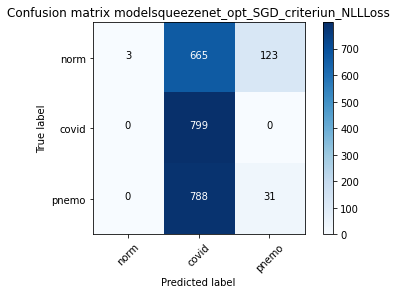

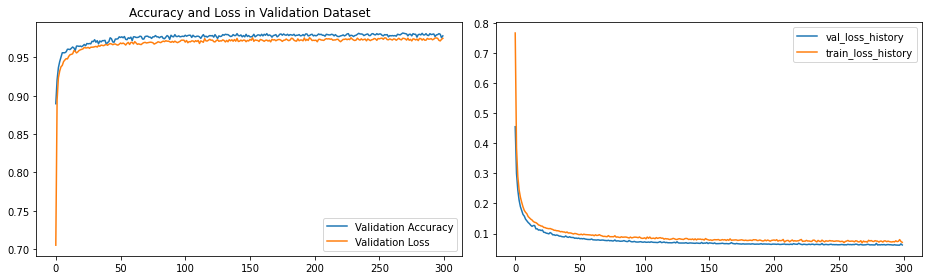


==== END ====
[[791   0   0]
 [  0 779  20]
 [  4  20 795]]

Sensitivity or recall total
0.9817351598173516

Sensitivity or recall per classes
[1.   0.97 0.97]

Precision
[0.99 0.97 0.98]

F1 Score
[1.   0.97 0.97]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 2
criteriun -> 2

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: -17.8177 Acc: 0.3258
val Loss: -35.0713 Acc: 0.3520

Epoch 1/299
----------
train Loss: -51.4627 Acc: 0.3474
val Loss: -68.1625 Acc: 0.3570

Epoch 2/299
----------
train Loss: -84.2700 Acc: 0.3555
val Loss: -100.9338 Acc: 0.3715

Epoch 3/299
----------
train Loss: -116.8398 Acc: 0.3784
val Loss: -133.5810 Acc: 0.3944

Epoch 4/299
----------
train Loss: -149.4152 Acc: 0.3889
val Loss: -166.2083 Acc: 0.4363

Epoch 5/299
----------
train Loss: -181.9471 Acc

train Loss: -2711.5150 Acc: 0.3516
val Loss: -2736.1843 Acc: 0.3499

Epoch 84/299
----------
train Loss: -2744.7060 Acc: 0.3530
val Loss: -2768.7091 Acc: 0.3495

Epoch 85/299
----------
train Loss: -2776.6680 Acc: 0.3527
val Loss: -2801.1878 Acc: 0.3495

Epoch 86/299
----------
train Loss: -2808.7930 Acc: 0.3505
val Loss: -2833.6347 Acc: 0.3487

Epoch 87/299
----------
train Loss: -2841.6621 Acc: 0.3505
val Loss: -2866.1572 Acc: 0.3487

Epoch 88/299
----------
train Loss: -2873.6348 Acc: 0.3514
val Loss: -2898.6800 Acc: 0.3495

Epoch 89/299
----------
train Loss: -2905.9592 Acc: 0.3503
val Loss: -2931.1855 Acc: 0.3491

Epoch 90/299
----------
train Loss: -2938.8332 Acc: 0.3500
val Loss: -2963.7121 Acc: 0.3495

Epoch 91/299
----------
train Loss: -2971.4509 Acc: 0.3528
val Loss: -2996.2315 Acc: 0.3495

Epoch 92/299
----------
train Loss: -3003.0830 Acc: 0.3514
val Loss: -3028.7598 Acc: 0.3524

Epoch 93/299
----------
train Loss: -3035.8381 Acc: 0.3526
val Loss: -3061.3416 Acc: 0.3524

E

val Loss: -5565.4315 Acc: 0.3553

Epoch 171/299
----------
train Loss: -5565.4746 Acc: 0.3545
val Loss: -5597.9612 Acc: 0.3566

Epoch 172/299
----------
train Loss: -5598.3068 Acc: 0.3545
val Loss: -5630.4534 Acc: 0.3562

Epoch 173/299
----------
train Loss: -5629.1885 Acc: 0.3553
val Loss: -5662.9564 Acc: 0.3557

Epoch 174/299
----------
train Loss: -5662.9058 Acc: 0.3547
val Loss: -5695.5046 Acc: 0.3553

Epoch 175/299
----------
train Loss: -5694.7483 Acc: 0.3550
val Loss: -5728.0136 Acc: 0.3553

Epoch 176/299
----------
train Loss: -5727.0389 Acc: 0.3550
val Loss: -5760.5137 Acc: 0.3553

Epoch 177/299
----------
train Loss: -5758.4841 Acc: 0.3549
val Loss: -5793.0341 Acc: 0.3553

Epoch 178/299
----------
train Loss: -5792.0631 Acc: 0.3542
val Loss: -5825.5660 Acc: 0.3545

Epoch 179/299
----------
train Loss: -5825.0117 Acc: 0.3542
val Loss: -5858.0373 Acc: 0.3541

Epoch 180/299
----------
train Loss: -5857.7291 Acc: 0.3533
val Loss: -5890.4943 Acc: 0.3537

Epoch 181/299
----------
t

train Loss: -8386.2788 Acc: 0.3548
val Loss: -8427.8291 Acc: 0.3545

Epoch 259/299
----------
train Loss: -8418.0670 Acc: 0.3537
val Loss: -8460.3291 Acc: 0.3545

Epoch 260/299
----------
train Loss: -8450.1666 Acc: 0.3544
val Loss: -8492.8545 Acc: 0.3545

Epoch 261/299
----------
train Loss: -8485.0819 Acc: 0.3538
val Loss: -8525.3720 Acc: 0.3545

Epoch 262/299
----------
train Loss: -8517.1916 Acc: 0.3531
val Loss: -8557.8737 Acc: 0.3545

Epoch 263/299
----------
train Loss: -8549.4590 Acc: 0.3542
val Loss: -8590.3924 Acc: 0.3541

Epoch 264/299
----------
train Loss: -8582.0229 Acc: 0.3534
val Loss: -8622.9058 Acc: 0.3545

Epoch 265/299
----------
train Loss: -8613.5608 Acc: 0.3542
val Loss: -8655.4343 Acc: 0.3545

Epoch 266/299
----------
train Loss: -8645.5920 Acc: 0.3547
val Loss: -8687.9449 Acc: 0.3545

Epoch 267/299
----------
train Loss: -8679.1320 Acc: 0.3539
val Loss: -8720.5191 Acc: 0.3545

Epoch 268/299
----------
train Loss: -8709.8133 Acc: 0.3536
val Loss: -8753.0925 Acc:

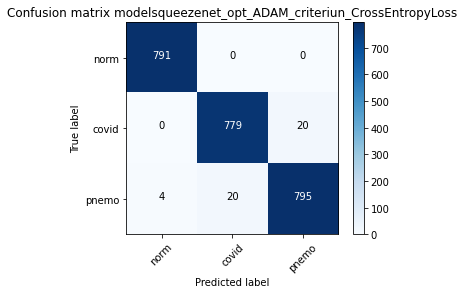

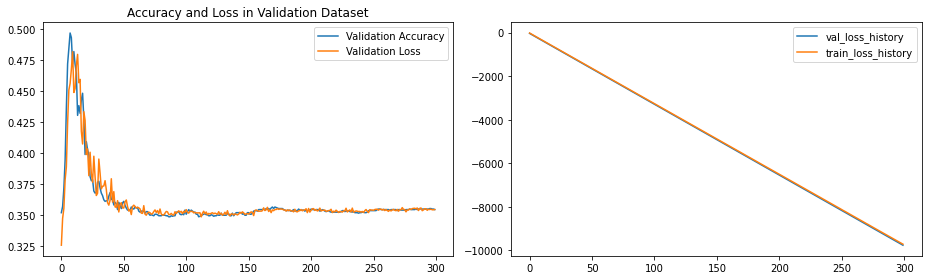


==== END ====
[[  2 322 467]
 [  0 642 157]
 [  1 265 553]]

Sensitivity or recall total
0.49688667496886674

Sensitivity or recall per classes
[0.   0.8  0.68]

Precision
[0.67 0.52 0.47]

F1 Score
[0.01 0.63 0.55]
Confusion matrix, without normalization

==== INITIALIZING WITH PARAMETERS: ====
model -> squeezenet
epochs -> 300
lr -> 0.0001
batch size -> 8
optimizer -> 3
criteriun -> 1

--------------------
Params to learn:
	 classifier.1.weight
	 classifier.1.bias

--------------------

== Epochs ==
Epoch 0/299
----------
train Loss: 0.5666 Acc: 0.8316
val Loss: 0.3645 Acc: 0.9070

Epoch 1/299
----------
train Loss: 0.3305 Acc: 0.9101
val Loss: 0.2604 Acc: 0.9328

Epoch 2/299
----------
train Loss: 0.2640 Acc: 0.9248
val Loss: 0.2165 Acc: 0.9431

Epoch 3/299
----------
train Loss: 0.2263 Acc: 0.9357
val Loss: 0.1920 Acc: 0.9494

Epoch 4/299
----------
train Loss: 0.2050 Acc: 0.9376
val Loss: 0.1764 Acc: 0.9527

Epoch 5/299
----------
train Loss: 0.1906 Acc: 0.9423
val Loss: 0.1619 A

train Loss: 0.0848 Acc: 0.9719
val Loss: 0.0760 Acc: 0.9780

Epoch 91/299
----------
train Loss: 0.0887 Acc: 0.9703
val Loss: 0.0722 Acc: 0.9772

Epoch 92/299
----------
train Loss: 0.0856 Acc: 0.9700
val Loss: 0.0729 Acc: 0.9763

Epoch 93/299
----------
train Loss: 0.0875 Acc: 0.9709
val Loss: 0.0722 Acc: 0.9772

Epoch 94/299
----------
train Loss: 0.0864 Acc: 0.9699
val Loss: 0.0718 Acc: 0.9768

Epoch 95/299
----------
train Loss: 0.0871 Acc: 0.9703
val Loss: 0.0721 Acc: 0.9776

Epoch 96/299
----------
train Loss: 0.0855 Acc: 0.9721
val Loss: 0.0731 Acc: 0.9776

Epoch 97/299
----------
train Loss: 0.0842 Acc: 0.9710
val Loss: 0.0715 Acc: 0.9772

Epoch 98/299
----------
train Loss: 0.0853 Acc: 0.9705
val Loss: 0.0718 Acc: 0.9788

Epoch 99/299
----------
train Loss: 0.0849 Acc: 0.9705
val Loss: 0.0725 Acc: 0.9768

Epoch 100/299
----------
train Loss: 0.0855 Acc: 0.9712
val Loss: 0.0724 Acc: 0.9772

Epoch 101/299
----------
train Loss: 0.0842 Acc: 0.9722
val Loss: 0.0725 Acc: 0.9763

Ep

train Loss: 0.0796 Acc: 0.9704
val Loss: 0.0654 Acc: 0.9805

Epoch 187/299
----------
train Loss: 0.0787 Acc: 0.9692
val Loss: 0.0642 Acc: 0.9809

Epoch 188/299
----------
train Loss: 0.0789 Acc: 0.9727
val Loss: 0.0649 Acc: 0.9801

Epoch 189/299
----------
train Loss: 0.0787 Acc: 0.9727
val Loss: 0.0688 Acc: 0.9784

Epoch 190/299
----------
train Loss: 0.0742 Acc: 0.9738
val Loss: 0.0648 Acc: 0.9809

Epoch 191/299
----------
train Loss: 0.0798 Acc: 0.9728
val Loss: 0.0661 Acc: 0.9797

Epoch 192/299
----------
train Loss: 0.0765 Acc: 0.9735
val Loss: 0.0649 Acc: 0.9792

Epoch 193/299
----------
train Loss: 0.0786 Acc: 0.9721
val Loss: 0.0641 Acc: 0.9805

Epoch 194/299
----------
train Loss: 0.0796 Acc: 0.9712
val Loss: 0.0646 Acc: 0.9813

Epoch 195/299
----------
train Loss: 0.0779 Acc: 0.9722
val Loss: 0.0642 Acc: 0.9809

Epoch 196/299
----------
train Loss: 0.0747 Acc: 0.9744
val Loss: 0.0647 Acc: 0.9813

Epoch 197/299
----------
train Loss: 0.0782 Acc: 0.9723
val Loss: 0.0672 Acc: 0

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
num_classes = 3

_models = ['squeezenet', 'densenet', 'resnet', 'alexnet', 'vgg']
lrs = [1e-4]
_epoch = [300]
batch_sizes = [8]
opt = [1, 2, 3]
crt = [1, 2]

for _model in _models:
    for _epochs in _epoch:
        for _lrs in lrs:
            for _batch in batch_sizes:
                for _opt in opt:
                    for _crt in crt:
                               
                        print()
                        print('='*60)
                        print('==== INITIALIZING WITH PARAMETERS: ====')
                        print(f'model -> {_model}')
                        print(f'epochs -> {_epochs}')
                        print(f'lr -> {_lrs}')
                        print(f'batch size -> {_batch}')
                        print(f'optimizer -> {_opt}')
                        print(f'criteriun -> {_crt}')
                        print()

                        feature_extract = True

                        model_ft, input_size = initialize_model(_model, num_classes, 
                                                                feature_extract, use_pretrained=True)

                        # Send the model to GPU
                        model_ft = model_ft.to(device)

                        print('-'*20)
                        params_to_update = model_ft.parameters()
                        print("Params to learn:")
                        if feature_extract:
                            params_to_update = []
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    params_to_update.append(param)
                                    print("\t",name)

                        else:
                            for name,param in model_ft.named_parameters():
                                if param.requires_grad == True:
                                    print("\t",name)


                        print()
                        print('-'*20)
                        print()
                        print('== Epochs ==')

                        if _opt == 1:
                            optimizer_ft = optim.SGD(params_to_update, _lrs, momentum=0.9)
                            opt_name = 'SGD'

                        if _opt == 2:
                            optimizer_ft = optim.Adam(params_to_update, _lrs)
                            opt_name = 'ADAM'
                            
                        if _opt == 3:
                            optimizer_ft = optim.RMSprop(params_to_update, _lrs)
                            opt_name = 'RMSprop'


                        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

                        #tray nn.NLLLoss
                        if _crt == 1:
                            criterion = nn.CrossEntropyLoss()
                            crt_name = 'CrossEntropyLoss'
                        if _crt == 2:
                            criterion = nn.NLLLoss()
                            crt_name = 'NLLLoss'

                        model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft,
                                                num_epochs=_epochs, model_name=_model, lr=_lrs,
                                                batch_size=_batch, opt_name=opt_name, crt_name=crt_name)

                        from sklearn.metrics import confusion_matrix

                        nb_classes = 3

                        # Initialize the prediction and label lists(tensors)
                        predlist=torch.zeros(0,dtype=torch.long, device='cpu')
                        lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

                        with torch.no_grad():
                            for i, (inputs, classes) in enumerate(dataloaders['val']):
                                inputs = inputs.to(device) #labels atuais
                                classes = classes.to(device) #classes
                                outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
                                _, preds = torch.max(outputs, 1) #pega o maior valor das predições

                                # Append batch prediction results
                                predlist=torch.cat([predlist,preds.view(-1).cpu()])
                                lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

                        # Confusion matrix
                        conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
                        print(conf_mat)
                        print()

                        from sklearn import metrics

                        #analise dos resultados do modelo
                        print('Sensitivity or recall total')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

                        print()
                        print('Sensitivity or recall per classes')
                        print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('Precision')
                        print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

                        print()
                        print('F1 Score')
                        print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))

                        cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
                        np.set_printoptions(precision=2)

                        plt.figure()

                        plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], 
                        title='Confusion matrix model'+_model+'_opt_'+opt_name+'_criteriun_'+crt_name)




Os resultados na matriz de confuzão e scores estão ruins, provavelmente pelo param.requires_grad = True 

Testar depois com False

**Peguei o código original**

In [ ]:
print()
print("------ RESULTADOS ------")
print()
plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="AUC Treino")
plt.plot(history.history['val_accuracy'], label="AUC VALIDAÇÃO")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="loss validação")
plt.plot(history.history['val_loss'], label="AUC validação")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
########## CAM try 1

In [ ]:
# # hook the feature extractor
# features_blobs = []
# def hook_feature(module, input, output):
#     features_blobs.append(output.data.cpu().numpy())

# model_ft._modules.get(finalconv_name).register_forward_hook(hook_feature)

# # get the softmax weight
# params = list(model_ft.parameters())
# weight_softmax = np.squeeze(params[-2].data.numpy())

# def returnCAM(feature_conv, weight_softmax, class_idx):
#     # generate the class activation maps upsample to 256x256
#     size_upsample = (256, 256)
#     bz, nc, h, w = feature_conv.shape
#     output_cam = []
#     for idx in class_idx:
#         cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
#         cam = cam.reshape(h, w)
#         cam = cam - np.min(cam)
#         cam_img = cam / np.max(cam)
#         cam_img = np.uint8(255 * cam_img)
#         output_cam.append(cv2.resize(cam_img, size_upsample))
#     return output_cam


In [ ]:
# normalize = transforms.Normalize(
#    mean=[0.485, 0.456, 0.406],
#    std=[0.229, 0.224, 0.225]
# )
# preprocess = transforms.Compose([
#    transforms.Resize((224,224)),
#    transforms.ToTensor(),
#    normalize
# ])

# response = requests.get(IMG_URL)
# img_pil = Image.open(io.BytesIO(response.content))
# img_pil.save('test.jpg')

# img_tensor = preprocess(img_pil)
# img_variable = Variable(img_tensor.unsqueeze(0))
# logit = model_ft(img_variable)

# # download the imagenet category list
# # classes = {int(key):value for (key, value)
# #           in requests.get(LABELS_URL).json().items()}

# # h_x = F.softmax(logit, dim=1).data.squeeze()
# # probs, idx = h_x.sort(0, True)
# # probs = probs.numpy()
# # idx = idx.numpy()

# # # output the prediction
# # for i in range(0, 5):
# #     print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# # generate class activation mapping for the top1 prediction
# CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# # render the CAM and output
# # print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
# img = cv2.imread('test.jpg')
# height, width, _ = img.shape
# heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
# result = heatmap * 0.3 + img * 0.5
# cv2.imwrite('CAM.jpg', result)

In [ ]:
# import IPython.display as display
# from PIL import Image
# image_path = 'CAM.jpg'
# display.display(Image.open(image_path))

In [ ]:
########## CAM try 1 FIIMMMM

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.405])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    #plt.pause(1)  # pause a bit so that plots are updated

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for i, (inputs, classes) in enumerate(dataloaders['test']):
        #inputs, labels = data

        #inputs, labels = Variable(inputs), Variable(labels)
        inputs = inputs.to(device) #labels atuais
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.figure(figsize=(20,20))
            ax = plt.subplot(5, 2, images_so_far)
            ax.axis('off')
            ax.set_title('{}'.format(class_names[predlist[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

#print(dir(model))
visualize_model(model_ft)

In [ ]:
# savePath = "test_model.pth"
# torch.save(model_ft.state_dict(), savePath)

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
########## CAM try 2

In [ ]:
#TRY CAM
#do it using RESNET

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd
from torch.autograd import Variable

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
#transforms.RandomRotation(degrees=(-5, 5)),
#transforms.ColorJitter(brightness=.02),
    
transformers = {
    'train_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'test_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'valid_transforms': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

trans = ['train_transforms','valid_transforms','test_transforms']

path = "/home/jimi/dissertacao/covid19/datasets/80-20/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x,
                                             transform=transformers[y]) for x,y in zip(categories, trans)}

dataset_sizes = ['train']


num_threads = 4 
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories}

dataset_sizes = {x : len(dset[x]) for x in ['train','val','test']}

class_names = dset['train'].classes

#class_names = image_datasets['train'].classes

# Detect if we have a GPU available
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
##### RESNET
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,3),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = True
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        
        if train_on_gpu:
            self.model = self.model.cuda()
            
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','val']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model
    
model = Model()
model_ft = model.fit(dataloaders,150)

from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


from sklearn import metrics

#analise dos resultados do modelo
print('Sensitivity or recall total')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average='micro'))

print()
print('Sensitivity or recall per classes')
print (metrics.recall_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('Precision')
print (metrics.precision_score(lbllist.numpy(), predlist.numpy(), average=None))

print()
print('F1 Score')
print (metrics.f1_score(lbllist.numpy(), predlist.numpy(), average=None))




epoch 1/150
----------


/home/jimi/.local/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train loss:  0.2888  acc: 0.8944
val loss:  0.1284  acc: 0.9601
epoch 2/150
----------
train loss:  0.2063  acc: 0.9219
val loss:  0.1282  acc: 0.9543
epoch 3/150
----------
train loss:  0.1757  acc: 0.9354
val loss:  0.1267  acc: 0.9560
epoch 4/150
----------
train loss:  0.1363  acc: 0.9510
val loss:  0.1089  acc: 0.9626
epoch 5/150
----------
train loss:  0.1402  acc: 0.9500
val loss:  0.1049  acc: 0.9639
epoch 6/150
----------
train loss:  0.1337  acc: 0.9523
val loss:  0.1090  acc: 0.9601
epoch 7/150
----------
train loss:  0.1313  acc: 0.9520
val loss:  0.0938  acc: 0.9697
epoch 8/150
----------
train loss:  0.1307  acc: 0.9532
val loss:  0.1055  acc: 0.9597
epoch 9/150
----------
train loss:  0.1345  acc: 0.9530
val loss:  0.1076  acc: 0.9585
epoch 10/150
----------
train loss:  0.1355  acc: 0.9513
val loss:  0.0982  acc: 0.9697
epoch 11/150
----------
train loss:  0.1377  acc: 0.9500
val loss:  0.1038  acc: 0.9618
epoch 12/150
----------
train loss:  0.1343  acc: 0.9495
val los

val loss:  0.1078  acc: 0.9601
epoch 95/150
----------
train loss:  0.1265  acc: 0.9554
val loss:  0.1039  acc: 0.9643
epoch 96/150
----------
train loss:  0.1323  acc: 0.9530
val loss:  0.1154  acc: 0.9577
epoch 97/150
----------
train loss:  0.1332  acc: 0.9523
val loss:  0.1198  acc: 0.9514
epoch 98/150
----------
train loss:  0.1277  acc: 0.9545
val loss:  0.1081  acc: 0.9610
epoch 99/150
----------
train loss:  0.1300  acc: 0.9506
val loss:  0.1105  acc: 0.9622
epoch 100/150
----------
train loss:  0.1307  acc: 0.9541
val loss:  0.1092  acc: 0.9606
epoch 101/150
----------
train loss:  0.1305  acc: 0.9518
val loss:  0.1016  acc: 0.9635
epoch 102/150
----------
train loss:  0.1291  acc: 0.9535
val loss:  0.0995  acc: 0.9664
epoch 103/150
----------
train loss:  0.1281  acc: 0.9536
val loss:  0.0957  acc: 0.9680
epoch 104/150
----------
train loss:  0.1319  acc: 0.9496
val loss:  0.1015  acc: 0.9643
epoch 105/150
----------
train loss:  0.1318  acc: 0.9521
val loss:  0.1059  acc: 0.

In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device) #labels atuais
        classes = classes.to(device) #classes
        outputs = model_ft(inputs) #valores preditos = Passa o label atual e retorna o que o modelo predice
        _, preds = torch.max(outputs, 1) #pega o maior valor das predições

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)
print()


In [ ]:
import itertools 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')





In [ ]:
cm = confusion_matrix(lbllist.numpy(), predlist.numpy())
np.set_printoptions(precision=2)

plt.figure()

plot_confusion_matrix(cm, classes=['norm', 'covid', 'pnemo'], title='Confusion matrix')

In [ ]:
data_dir_test = "/home/jimi/dissertacao/covid19/datasets/80-20/test/"

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      #transforms.Normalize([0.485, 0.456, 0.406],
                                      #                     [0.229, 0.224, 0.225])
                                     ])

In [ ]:
model_ft.eval()

In [ ]:
#print(model)

In [ ]:
#print(model_ft)

In [ ]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data,sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [ ]:
# plot predictions
to_pil = transforms.ToPILImage()
images, labels = get_random_images(30)
fig=plt.figure(figsize=(20,20))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    
    data = datasets.ImageFolder(data_dir_test, transform=test_transforms)
    classes = data.classes
    
    #print (f'index: {index}')
    #print (f'image: {image}')
    #print (f'labes: {labels}')
    #print (f'classes index :{classes[index]}')
    #print (f'classes 2:{classes}')
    
    sub = fig.add_subplot(8, 4, ii+1)
    
    #print()
    res = int(labels[ii]) == 1
    #print(f'int(labels[ii]): {int(labels[ii])}')
    #print(f'index: {index}')
    #print(f'res = int(labels[ii]) == index: {res}')
    #print()
    
    #print (f'res : {res}')
    
    sub.set_title(str(classes[1]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self,model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/1785.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/860.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/normal/2480.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/test/covid/000001-9-a.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/covid/3010b.png'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/pneumonia/1705.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/pneumonia/100.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
image_path = '/home/jimi/dissertacao/covid19/datasets/80-20/val/pneumonia/3104.jpg'
img = image_loader(image_path).cuda()

acts = LayerActivations(model_ft)

logps = model_ft(img).cuda()
ps = torch.exp(logps)

out_features = acts.features[0]
out_features = torch.squeeze(out_features, dim=0)
out_features = out_features.cpu().detach().numpy()
out_features = np.transpose(out_features,axes=(1,2,0))

W = model_ft.fc[0].weight
top_probs, top_classes = torch.topk(ps, k=3)
ps = ps.cpu().detach().numpy()
pred = np.argmax(ps)
w = W[pred,:]

w = w.cpu().detach().numpy()
cam = np.dot(out_features, w)
#type(w)

class_activation = nd.zoom(cam, zoom=(32,32),order=1)

img = torch.squeeze(img,0)
img = img.cpu().numpy()
img = np.transpose(img,(1,2,0))
mean = np.array([0.5,0.5,0.5])
std =  np.array([0.5,0.5,0.5])
#img = img.cpu().numpy()
img = (img + mean) * std
img = np.clip(img, a_max=1, a_min=0)

plt.imshow(class_activation, cmap='jet',alpha=1)
plt.imshow(img, alpha=0.55)
plt.title(dset['val'].classes[pred])


In [ ]:
########## CAM try 2 FIIMMMM

In [24]:
########## CAM try 2 FIIMMMM

In [25]:
########## CAM try 2 FIIMMMM

In [ ]:
########## CAM try 3 ref - https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19

In [ ]:
########## CAM try 3 ref

In [ ]:
########## CAM try 3 ref- https://github.com/ironWolf1990/pytorch-covid19
########## CAM try 3 ref
########## CAM try 3 ref
########## CAM try 3 ref

In [ ]:
# utils.py

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, gridspec
from sklearn.manifold import TSNE


def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        cmap = cm.get_cmap("rainbow")
        c = cmap(int(255 * s / 9))
        plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.show()
    plt.pause(0.01)

def data_viz(layer, label):
    # https://github.com/MorvanZhou/PyTorch-Tutorial/blob/master/tutorial-contents-notebooks/401_CNN.ipynb
    tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(layer.data.numpy()[:plot_only, :])
    labels = label.numpy()[:plot_only]
    plot_with_labels(low_dim_embs, labels)


def plot_test_image_result(img, ps, le, cam=None):

    _ = plt.figure(figsize=(8, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

    if cam is not None:
        ax1.imshow(cam, alpha=0.6)
        ax1.imshow(img, alpha=0.4)
    else:
        ax1.imshow(img)

    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))

    for i, v in enumerate(ps):
        ax2.text(
            .01,
            i-0.1,
            f'{v:.3f}',
            color='blue',
            fontweight='bold')

    if le is None:
        ax2.set_yticklabels(np.arange(len(ps)))
    else:
        ax2.set_yticklabels(le.inverse_transform(np.arange(len(ps))))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [ ]:
# makedataset.py

from os.path import isfile, join
from os import walk
import pandas as pd
import numpy as np
from itertools import tee

from sklearn.model_selection import train_test_split

if __name__ == "__main__":

    path = "./data"
    sample_per_category = 500
    seed = 24
    split_frac = 0.20

    df_raw = None

    genFiles = (
        (dirpath, dirnames, filenames) for (dirpath, dirnames, filenames) in walk(path)
    )

    files, genFiles = tee(genFiles)
    file_count = sum(len(f) for _, _, f in files)

    df_raw = pd.DataFrame(
        data=np.nan, index=np.arange(0, file_count - 1), columns=["LABEL", "FILE"]
    )

    files, genFiles = tee(genFiles)
    idx = 0
    for r, _, f in files:
        for _f in f:
            if isfile(join(r, _f)) and _f.endswith(
                (".jpeg", ".png", "jpg", ".JPEG", ".PNG", "JPG")
            ):
                path = "/".join((r, _f))
                *_, label = r.split("/")
                df_raw.iloc[idx] = [label, path]
                idx += 1

    df_raw.to_csv("./data/raw.csv", index=False)

    # # 3-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 3),
        columns=["FILE", "LABEL"],
    )

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/3_class_train_df.csv", index=False)
    test_df.to_csv("./data/3_class_test_df.csv", index=False)

    print(f"\n3_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"3_class_test_df:\n{test_df['LABEL'].value_counts()}")

    # 2-class
    df_main = pd.DataFrame(
        data=np.nan,
        index=np.arange(0, sample_per_category * 2),
        columns=["FILE", "LABEL"],
    )

    index = df_raw[df_raw["LABEL"] == "pneumonia"].index
    df_raw.drop(index, inplace=True)

    df_main = df_raw.groupby("LABEL").apply(
        lambda s: s.sample(n=min(len(s), sample_per_category), random_state=seed)
    )

    train_df, test_df = train_test_split(
        df_main, random_state=seed, test_size=split_frac, shuffle=True
    )

    train_df.to_csv("./data/2_class_train_df.csv", index=False)
    test_df.to_csv("./data/2_class_test_df.csv", index=False)

    print(f"\n2_class_train_df:\n{train_df['LABEL'].value_counts()}")
    print(f"2_class_test_df:\n{test_df['LABEL'].value_counts()}")

In [ ]:
# architectures.py

import torch.nn as nn
from torchvision.models import resnet50


class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class Rn50(nn.Module):
    def __init__(self, device, train_base=False, classes=2):
        super(Rn50, self).__init__()

        self.device = device

        self.net_back = resnet50(pretrained=True).to(self.device)
        self._trainable(train_base)

        fc_size = self.net_back.fc.in_features
        self.net_back.fc = Identity()

        self.net_head = nn.Sequential(
            nn.Linear(in_features=fc_size, out_features=1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=classes),
            nn.LogSoftmax(dim=1),
        ).to(self.device)

    def forward(self, x):
        x = self.net_back(x.to(self.device))
        x = x.view(x.size(0), -1)
        return self.net_head(x.to(self.device))

    def _trainable(self, flag):
        for param in self.net_back.parameters():
            param.requires_grad = flag


# old way
# modules = list(resnet50(pretrained=True).children())[:-1]
# self.net_back = nn.Sequential(*modules).to(self.device)
# fc_size = list(self.net_back.parameters())[-1].size(0)
# self.net_head = nn.Sequential(...).to(self.device)

In [ ]:
# activationmap.py

import torch


class FeatureBuffer():

    features=None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        # self.features = ((output.cpu()).data).numpy()
        self.features = output

    def remove(self):
        self.hook.remove()


# def GradCam(model, input_image_tensor):

#     https://github.com/tyui592/class_activation_map/blob/master/cam.py
#     https://github.com/daixiangzi/Grad_Cam-pytorch-resnet50/blob/578db29d13b0e7d17aa53d9bac116674771618ec/test_grad_cam.py#L19
#     https://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html.html
#     https://github.com/MarcoCBA/Class-Activation-Maps-PyTorch/blob/master/class_activation_maps.ipynb

#     print(model)

#     final_conv_layer = model.net_back._modules.get('layer4')
#     fc_layer = model.net_head._modules.get('0')
#     fb = FeatureBuffer(final_conv_layer)

#     model = model.eval()
#     out = model(input_image_tensor)

#      # based on model caluculate output!!!
#     probabilities = torch.exp(out)
#     _, predicted = torch.max(probabilities, 1)
#     feature_maps = fb.features

#     print("Output's shape: ", out.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     weights_and_biases = list(fc_layer.parameters())
#     class_weights = weights_and_biases[0][predicted]
#     print("Weights's shape: ", weights_and_biases[0].shape)
#     print("Biases's shape: ", weights_and_biases[1].shape)
#     print("Class weights's shape :", class_weights.shape)

#     class_weights = class_weights.reshape((-1, 1, 1))
#     feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
#     print("Class weights's shape :", class_weights.shape)
#     print("Feature maps's shape: ", feature_maps.shape)

#     class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(class_activation_maps)
#     plt.show()

#     resized_cam = cv2.resize(class_activation_maps, dsize=(224, 224), interpolation=cv2.INTER_LANCZOS4)
#     plt.figure(figsize=(6, 6))
#     plt.imshow(resized_cam)
#     plt.show()

In [ ]:
# train.py

import math
from time import time
from copy import deepcopy

import torch

try:
    from torchsummary import summary
except:
    MODELSUMMARY = False
else:
    MODELSUMMARY = True

try:
    from sklearn.manifold import TSNE
except:
    VIZTSNE = False
else:
    VIZTSNE = True


def train_model(
    model,
    device,
    criterion,
    optimizer,
    dataloaders,
    dataloader_len,
    input_shape,
    scheduler=None,
    num_epochs=50,
):

    if MODELSUMMARY:
        summary(model, input_data=input_shape)

    start = time()
    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        t_epoch = time()
        print(f"epoch: {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for idx, (labels, inputs) in enumerate(dataloaders[phase]):
                iter_batch = math.ceil(
                    dataloader_len[phase] / dataloaders[phase].batch_size
                )
                print(f"[phase: {phase}] batch: {idx+1}/{iter_batch}", end="\r")

                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                if scheduler is not None:
                    scheduler.step()

            epoch_loss = running_loss / dataloader_len[phase]
            epoch_acc = running_corrects.double() / dataloader_len[phase]
            print(f"[phase: {phase}] Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == "val" and epoch_acc > best_acc:
                print(f"[saving model] epoch: {epoch+1} Acc: {epoch_acc:.4f}")
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        t_elapsed = time() - t_epoch
        print(f"epoch training complete in {t_elapsed//60:.0f}m {t_elapsed%60:.0f}s")
        print()

    time_elapsed = time() - start
    print(f"training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"best val Acc: {best_acc:4f}")

    model.load_state_dict(best_model_wts)

    checkpoint = {
        "input_shape": input_shape,
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }

    torch.save(checkpoint, "./models/checkpoint.pth")
    return model

In [ ]:
# test.py

import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scripts.activationmap import FeatureBuffer
from sklearn.metrics import classification_report, confusion_matrix

#from .utils import plot_test_image_result


def test_model(model, testloader, device, encoder=None):

    correct = 0
    total = 0
    true_list = list()
    pred_list = list()

    for idx, (labels, inputs) in enumerate(testloader):
        iter_batch = math.ceil(len(testloader.dataset)/testloader.batch_size)
        print(f'[phase: test] batch: {idx+1}/{iter_batch}', end='\r')

        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            probabilities = torch.exp(outputs)
            _, predicted = torch.max(probabilities, 1)

            total = idx + 1
            correct += torch.sum(predicted == labels.data)
            true_list.append((labels.data.cpu()).numpy().item())
            pred_list.append((predicted.cpu()).numpy().item())

    acc = 100*(correct.item()/total)
    print(f"[phase: test] total: {total}, correct: {correct}, acc: {acc:.3f}")

    print(classification_report(tuple(true_list), tuple(pred_list)))

    y_true = pd.Series(true_list, name='Actual')
    y_pred = pd.Series(pred_list, name='Predicted')
    cm = pd.crosstab(y_true, y_pred,  margins=True)

    print("confusion matrix")
    if encoder is not None:
        print({i : encoder.classes_[i] for i in range(0, len(encoder.classes_))})
    print(cm)



def test_image(model, image, in_shape, transform, device, labelencoder=None, cam=None):
    """
    GradCam
    """

    if cam is not None:
        final_conv_layer = model.net_back._modules.get('layer4')
        fc_layer = model.net_head._modules.get('0')
        fb = FeatureBuffer(final_conv_layer)

    input_tensor = transform(image).unsqueeze(0)
    inputs = input_tensor.to(device)

    model = model.eval()
    outputs = model(inputs)
    probabilities = torch.exp(outputs)
    prob = (probabilities.cpu()).detach().numpy().flatten()

    if cam is not None:
        _, predicted = torch.max(probabilities, 1)
        feature_maps = fb.features

        weights_and_biases = list(fc_layer.parameters())
        class_weights = weights_and_biases[0][predicted]

        class_weights = class_weights.reshape((-1, 1, 1))
        feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)

        class_activation_maps = np.array(
            torch.sum(feature_maps * class_weights, dim=0).cpu().detach(),
            dtype=np.float32)

        cam_map = cv2.resize(
            class_activation_maps,
            dsize=in_shape,
            interpolation=cv2.INTER_LANCZOS4)

    if cam is not None:
        plot_test_image_result(image.resize(in_shape), prob, labelencoder, cam_map)
    else:
        plot_test_image_result(image, prob, labelencoder)

In [ ]:
# evaluate.py 

import torch
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from PIL import Image

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.test import test_model, test_image


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"

test_file = "data/3_class_test_df.csv"
image_file = "data/raw/covid/covid_001.jpg"
num_workers = 2
batch_size = 1
input_shape = (256, 256)
le = LabelEncoder()

df = pd.read_csv(test_file)

test_transforms = transforms.Compose(
    [
        transforms.Resize(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

test_set = Datagen(df, l_encoder=le, transforms=test_transforms)
label_enc = test_set.get_le()
device = get_device()

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, num_workers=num_workers,
)

model = Rn50(device=device, classes=3)
model.load_state_dict(torch.load("./models/checkpoint.pth")["state_dict"])

test_model(
    model=model,
    testloader=test_loader,
    device=device,
    encoder=label_enc)

input_image = Image.open(image_file).convert("RGB")
test_image(
    model=model,
    image=input_image,
    in_shape=input_shape,
    transform=test_transforms,
    device=device,
    labelencoder=label_enc,
    cam=True
)

In [ ]:
# datagen.py

from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from PIL import Image


class Datagen(Dataset):
    def __init__(self, dataframe, transforms=None, l_encoder=None):
        self.df = dataframe
        self.transforms = transforms
        self.encoder = l_encoder

        if self.encoder is not None:
            self.df["LABEL"] = self.encoder.fit_transform(self.df["LABEL"])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        label = self.df.iloc[idx, 0]
        image_file = self.df.iloc[idx, 1]
        image = Image.open(image_file).convert("RGB")

        if self.transforms:
            image = self.transforms(image)

        # print(image.shape)
        return (label, image)

    def get_le(self):
        return self.encoder

In [ ]:
# trainer.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd

from scripts.datagen import Datagen
from scripts.architectures import Rn50
from scripts.train import train_model


def get_device():
    if torch.cuda.is_available():
        return "cuda:0"
    else:
        return "cpu"


train_file = "data/3_class_train_df.csv"
num_workers = 2
val_split = 0.2
batch_size = 32
num_epochs = 20
input_shape = (3, 256, 256)
le = LabelEncoder()

df = pd.read_csv(train_file)

train_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

validation_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

train_set = Datagen(df, l_encoder=le, transforms=train_transforms)
validation_set = Datagen(df, l_encoder=le, transforms=validation_transforms)

train_idx, val_idx = train_test_split(list(range(len(df))), test_size=val_split)
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(val_idx)

train_loader = torch.utils.data.DataLoader(
    train_set,
    # shuffle=True,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers,
)

valid_loader = torch.utils.data.DataLoader(
    validation_set,
    # shuffle=False,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers,
)

device = get_device()
net = Rn50(device=device, classes=3)

dataloaders = {"train": train_loader, "val": valid_loader}
dataloader_len = {"train": len(train_idx), "val": len(val_idx)}

criteration = nn.NLLLoss()
optimizer = optim.Adam(net.parameters())
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(
    model=net,
    device=device,
    criterion=criteration,
    optimizer=optimizer,
    dataloaders=dataloaders,
    dataloader_len=dataloader_len,
    input_shape=input_shape,
    num_epochs=num_epochs,
)

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM

In [ ]:
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM
########## CAM try 3 FIM

In [ ]:
########## CAM functional

In [ ]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import numpy as np
import cv2
import pdb

# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'https://diariodonordeste.verdesmares.com.br/image/contentid/policy:1.2966908:1594933666/ferramenta-sesa.jpg'

# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 1
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

#net.eval()

In [ ]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [ ]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   normalize
])

response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable) ## aqui tem algo

# # download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

# # output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM.jpg', result)

In [ ]:
import IPython.display as display
from PIL import Image
image_path = 'CAM.jpg'
display.display(Image.open(image_path))

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")